# NN Walkthrough

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# for creating animations
import matplotlib.animation
from IPython.display import HTML

In [2]:
# styling additions
from IPython.display import HTML
# style = "<style>div.warn{background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
style = "<style>div.info{padding: 15px; border: 1px solid transparent; border-left: 5px solid #dfb5b4; border-color: transparent; margin-bottom: 10px; border-radius: 4px; background-color: #fcf8e3; border-color: #faebcc;}</style>"
HTML(style)

## Latex definitions
This cell just creates some latex definitions we will need later:
$$
\newcommand{\dc}{\color{red}{\partial C_0}}
\newcommand{\dw}{\color{blue}{\partial w^{(L)}}}
\newcommand{\dz}{\color{green}{\partial z^{(L)}}}
\newcommand{\da}{\color{orange}{\partial a^{(L)}}}
\newcommand{\dcdw}{\frac{\dc}{\dw}}
\newcommand{\dzdw}{\frac{\dz}{\dw}}
\newcommand{\dadz}{\frac{\da}{\dz}}
\newcommand{\dcda}{\frac{\dc}{\da}}
$$

 # Forward Direction

Lets start with the simplest network we can imagine, and first understand how a neural network calculates its output for a particular input. This is known as the "forward" direction (we will see why later). 

## Dataset

Lets generate a simple 1-D toy dataset:

In [3]:
def toy():
    N = 1000
    inputs = np.linspace(-5,5,N).reshape(N,1)
    labels = ((inputs>0).astype(int)*2-1).reshape(N,1)
    return inputs,labels

In [4]:
inputs,labels = toy()
inputs[0],labels[0]

(array([-5.]), array([-1]))

## 1-D Network

Lets give the simplest network we can imagine. One that consists of a few 1-D "layers" of size 1! We have an:
* input node/layer, 
* hidden node/layer:$h_1$, 
* another hidden node/layer $h_2$
* output node/layer. 

Networks are typically drawn with the **weights** on the wires. Our simple network can be given as:
![](figures/simple_network.png)

<div class="info">

**Note:** This is sometimes confusing, as technically its the **activations** of the previous layer that "flow" into the next layer. However, the weights are what we are tying to **learn**, and their relative **strengths** tells us something about the structure of the network.
    
</div>


Each node has an assocaited:
* weight
* bias
* activation function

In our example, we have $w_1,b_1,w_2,b_2,w_3,b_3$ as our **parameters** and we are using the **sigmoid** as our activation function.

The function of each node, is to apply its own weight and bias to a previous layers activation value, and then pass it through its activation function to produce its own activation. For example, $h_1$ is doing:

$$
a_1 = \sigma(w\cdot x + b)
$$

The *input* to a nodes activation function is useful to think about separately, so we can introduce an additional variable to denote it as:
$$
z_i = w\cdot x + b, \quad\quad a_1 = \sigma(z_i)
$$

So, we can descrive the behavior of each of our nodes as:

![](figures/nodes.png)

### Implementation

Now we can actually implement this simple network. Lets start by recalling the sigmoid function:

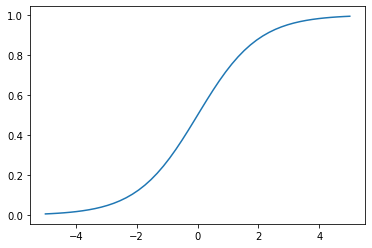

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

plt.plot(np.linspace(-5,5),sigmoid(np.linspace(-5,5)));

Lets define the function of a **node**, being careful to match our notation:

In [6]:
def node(w,b,a):
    # EDIT HERE
    return sigmoid(z)

Now we are ready to define our **actual network**! Lets initialize our random weights and biases:

In [7]:
w1,b1,w2,b2,w3,b3 = np.random.rand(6)

Now, lets pick a training example and run it through our network:

In [8]:
input,label = inputs[0],labels[0]

# h1 node - operates on our input
a1 = # EDIT HERE

# h2 node - operates on a1
a2 = # EDIT HERE

# output node - operates on a2 - produces our output
output = # EDIT HERE
y_hat = output

Lets see how we did!

In [9]:
print(f"for input: {input} with label: {label}, this network calculated: {y_hat}")

for input: [-5.] with label: [-1], this network calculated: [0.6270142]


As we know, to actually see how we did, we need to **define a cost**! Lets proceed with the usual average-MSE:

In [10]:
def mse(y_hat,y,average=True):
    if average:
        return # EDIT HERE
    else:
        return # EDIT HERE

In [11]:
print(f"for input: {input} with label: {label}, this network calculated: {output}, giving us a cost of: {mse(output,label)}")

for input: [-5.] with label: [-1], this network calculated: [0.6270142], giving us a cost of: 2.647175196713521


Ok - so we've demonstrated the entire forward direction, for one sample. Lets define a function for this simple network, so we can run our entire training set through!

In [12]:
def simple_network(inputs):
    outputs = []
    N = inputs.shape[0]
    
    # initialized weights
    w1,b1,w2,b2,w3,b3 = np.random.rand(6)

    for i in range(N):
        input = inputs[i,:]
        
        # h1 node
        a1 = # EDIT HERE

        # h2 node
        a2 = # EDIT HERE

        # output node
        output = # EDIT HERE
        
        # append to form output
        outputs.append(output)
    
    return np.asarray(outputs)

We can now calculate our **average loss** over the entire training set:

In [13]:
mse(simple_network(inputs),labels)

1.592503019308129

## Multidimensional Network


We've looked at a very simple example above which captures the essence of what we are doing. However, our networks are really never actually composed of layers with one element each. Instead, **each** layer has **multiple** nodes. 

Technically, we could continue in the same way as above and individually number our weights and biases but this quickly gets out of hand! As an exercise, try repeating the above analysis and implementation where each hidden layer is now of size 2!

Ironically, to avoid this notational complexity, it seems like we must introduce additional notation, and rewrite our problem in the language of **linear algebra**. 

To introduce this notation, lets imagine a network the following structure:
![](figures/md-1.png)

To make our analysis simpler, lets zoom in on node node, and all of its input weights:

![](figures/md-2.png)

We've highlihted the 0th node in our last hidden layer and all of its inputs from the previous layer in $\color{orange}{\text{orange}}$. We've also numbered each of it input nodes with their layer-specific numbering and shown them in $\color{blue}{\text{blue}}$.

We've also named each weight according to the following format:

$$
w_{\;\color{orange}{\text{current node #}} \;,\; \color{blue}{\text{incoming node #}}}
$$

This may seem a bit counter intuitive at first, as the tendency when reading from left to write is to want to write our weights as:

$$
w_{\;\color{blue}{\text{incoming node #}} \;,\; \color{orange}{\text{current node #}} }
$$

You absolutely can, but that will result in a bunch of transposes in later equations. To get rid of them now, we will number our weights as we did above. As is typically the case, people make seemingly weird/arbitrary decisions at the front to result in simplifications down the line. 

Recall, the function of a node is to apply its weight to the activation of its input/previous layer. In this case, we have three previous nodes/input nodes, so we will also write them in $\color{blue}{\text{blue}}$ to make it clear that they are coming from the previous layer. 

So our orange node is performing:

$$
\color{orange}{w}_{\color{orange}{0},\color{blue}{0}} \cdot \color{blue}{a_0} + 
\color{orange}{w}_{\color{orange}{0},\color{blue}{1}} \cdot \color{blue}{a_1} + 
\color{orange}{w}_{\color{orange}{0},\color{blue}{2}} \cdot \color{blue}{a_2} + 
\color{orange}{b_0}
$$

Already, our eyes should be screaming **dot-product**! 

### Notation

Indeed, we can form a **vector** of the <font color='blue'>**previous layer's**</font> activations as:

$$
\color{blue}{\mathbf{a}_{prev}} = 
\begin{bmatrix}
\color{blue}{a_0 \\
a_1 \\
a_2}
\end{bmatrix}
$$

and a **vector** of the 0-th neurons **weights** in the <font color="orange">**current layer**</font> as:

$$
\color{orange}{\mathbf{w}_0} = 
\begin{bmatrix}
\color{orange}{w}_{\color{orange}{0},\color{blue}{0}} \\
\color{orange}{w}_{\color{orange}{0},\color{blue}{1}} \\
\color{orange}{w}_{\color{orange}{0},\color{blue}{2}}
\end{bmatrix}
$$

where we have used color again to make it clear what layer we are talking about: the <font color='orange'>current</font> or <font color='blue'>previous</font> layer.

Then we can rewrite what our orange node is calculating as:
$$
\begin{align}
\color{orange}{z_0} &= \color{orange}{\mathbf{w}_0} \cdot \color{blue}{\mathbf{a}_{prev}} + \color{orange}{b_0} \\
\color{orange}{a_0} &= \sigma(\color{orange}{z_0})
\end{align}
$$

Well, we've managed to rewrite the activation of **one-node** in slightly better notation. But we can we do better! Lets now reason about the entire layer!

Recall, we already have a vector of the <font color='blue'>**previous layer's** </font>activations in $\color{blue}{\mathbf{a}_{prev}}$, although we never actually gave a formula for it. Based on the formula for the <font color='orange'>0th-node</font> in the <font color='orange'>current layer</font> we just gave, lets try to give a **vector** of activations for the entire <font color='orange'>**current layer**</font>. 

(Note: to prevent a color explosion, since we're talking about the current layer, I will drop orange to refer to it most places. I will keep blue to refer to the previous layer).

To simplify our analysis, lets first note that:
$$
\mathbf{a}_{curr} = 
\begin{bmatrix}
\sigma (z_0) \\
\sigma (z_1) \\
\sigma (z_2) \\
\end{bmatrix} = 
\sigma\left(\;
\begin{bmatrix}
z_0 \\
z_1 \\
z_2 \\
\end{bmatrix}\;
\right) = 
\sigma (\mathbf{z}_{curr})
$$

So, lets focus on writing a formula for the vector $\mathbf{z}_{curr}$:

$$
\mathbf{z}_{curr} = 
\begin{bmatrix}
\mathbf{w}_0 \cdot \color{blue}{\mathbf{a}_{prev}} + b_0 \\
\mathbf{w}_1 \cdot \color{blue}{\mathbf{a}_{prev}} + b_1 \\
\mathbf{w}_2 \cdot \color{blue}{\mathbf{a}_{prev}} + b_2 \\
\end{bmatrix}
$$

Lets make it a bit clearer by writing our biases for the entire layer as a separte **vector** $\mathbf{b}$:

$$
\mathbf{z}_{curr} = 
\begin{bmatrix}
\mathbf{w}_0 \cdot \color{blue}{\mathbf{a}_{prev}} \\
\mathbf{w}_1 \cdot \color{blue}{\mathbf{a}_{prev}} \\
\mathbf{w}_2 \cdot \color{blue}{\mathbf{a}_{prev}}  \\
\end{bmatrix}
+
\mathbf{b}
$$

Just like we saw when we discussed linear regression, this vector of dot products is exactly the **matrix-vector** product of the **weight matrix** and the previous layers **activation vector**!

<div class="info">

**Definition**: The current layers **weight matrix**: $\mathbf{W}$  is a matrix of $k$-many rows, and $j$-many columns, where $k$ is the number of nodes in the current layer, and $j$ is the number of nodes in the previous layer:

$$
\mathbf{W} \in \mathbb{R}^{k,j}= 
\begin{bmatrix}
\mathbf{w}_0^T \\
\mathbf{w}_1^T \\
\ldots \\
\mathbf{w}_k^T
\end{bmatrix} = 
\begin{bmatrix}
w_{0,0} & w_{0,1} & \ldots & w_{0,j} \\
\ldots \\
w_{k,0} & w_{0,1} & \ldots & w_{k,j} \\
\end{bmatrix}
$$

**Note**: each row of the weight matrix represents all inputs to a specific node in the current layer.
    
</div>

Now, we can finally write a complete linear algebraic equation for the function of a current layer on a previous layer:

$$
\begin{align}
\mathbf{z}_{curr} &= \mathbf{W}\mathbf{a}_{prev}+\mathbf{b} \\
\mathbf{a}_{curr} &= \sigma(\mathbf{z}_{curr})
\end{align}
$$

Now, neural networks do this sequentially, so the last piece of the puzzle is to be able to refer to a specific layer by number. We now introduce the final piece of notation to let us do this: a **superscript** to designate the layer number:

<div class="info">

The activation of layer $L$ is given by:
    
$$
\begin{align}
\mathbf{z}^L &= \mathbf{W}^L \mathbf{a}^{L-1}+\mathbf{b}^L \\
\mathbf{a}^L &= \sigma(\mathbf{z}^L)
\end{align}
$$

This is often written succintly as:

$$
\boxed{\mathbf{a}^L = \sigma(\mathbf{W}\mathbf{a}^{L-1} + \mathbf{b})}
$$

where the specific $\mathbf{W},\mathbf{b}$ we are talking about is implied.
</div>

Wow we've come a long way! We've given a very clear and succinct linear algebraic equation for the entire forward direction for a network of any number of layers and size of each layer!

Lets perform a size sanity check: $\mathbf{W}$ is of size $k \times j$, where $j$ is the number of nuerons in the previous layer. $\mathbf{a}^{L-1}$ is a vector of size $j \times 1$, the activations of the previous layer. Their multiplication results in a vector of size $k \times 1$, where $k$ is the number of neurons in the current layer. Our bias vector is also $k \times 1$ (as we expect!). So everything works as expected! 

This is why we decided to write our weight matrix to be of size $k \times j$ or $\text{# neurons in prev label} \times \text{# neurons in current level}$ instead of the other way around. If we had, we'd need a transpose in the equation above.

### Implementation

Armed with our new notation, lets write an implementation of the network we gave above:

![](figures/md-1.png)

In [14]:
inputs,labels = toy()

In [15]:
def simple_network2(inputs):
    outputs = []
    N = inputs.shape[0]
    
    # initialize weight matrices - notice the dimensions
    W_1 = # EDIT HERE
    W_2 = # EDIT HERE
    W_3 = # EDIT HERE
    
    # and our biases
    b_1 = # EDIT HERE
    b_2 = # EDIT HERE
    b_3 = # EDIT HERE
    
    # loop through training data
    for i in range(N):
        
        # correct size for current input
        input = inputs[i,:]
        
        # layer 1
        a_1 = # EDIT HERE

        # layer 2
        a_2 = # EDIT HERE

        # output layer
        output = # EDIT HERE
        
        # append to form output
        outputs.append(output)
    
    return np.squeeze(np.asarray(outputs)).reshape(-1,1)

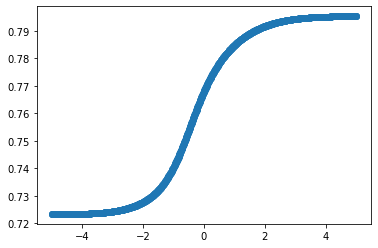

In [16]:
outputs = simple_network2(inputs)
plt.scatter(inputs,outputs);

## Mini-Batch Notation

Note, this implementation runs an example through the network **one-by-one**! Instead, we can imagine feeding our entire dataset throught **at once**! This formulism will pave the way for us later to feed in a mini-batch at a time.

Lets just reason our way through this one from first-principles (fancy way to say: lets match our matrix sizes!), seeing how we get our entire dataset through the first hidden layer. 

The first weight matrix of size:

$$
\mathbf{W}_1: (\text{size of hidden layer} \times \text{dimension of input})
$$

which in this case is: $3 \times 1$. If our input was 2-D, it would be $3 \times 2$. So what we *dot* it with, needs to be of size: $\text{dimension of input} \times \text{??}$. Its in that dimension that we can place our entire dataset! 

So, now we're going to be shuffling **activation matrices** around! In these activation matrices, each **column** is an activation for the last layer on a different training example! So we expect the first activation matrix to be of size: $\text{dimension of input} \times \text{number of inputs}$. This means this must also be the size of the initial $a^0=input$ matrix for the first hidden layer. 


So, we can rewrite our layer propagation equation above for our entire dataset:

$$
\boxed{\mathbf{A}^L = \sigma(\mathbf{W}\mathbf{A}^{L-1} + \mathbf{b})}
$$

where we use broadcasting rules to let us add a vector $\mathbf{b}$ to a matrix. 

Lets make a special note about the first layer. Typically, we imagine data being fed into a network where the first dimension is the `batch_size`. So if our data mtrix is of size $\text{batch_size} \times \text{dimension}$, in order for our first layer to calcualte correctly, we have to make the sizes work! Meaning, our first layer should be: 

$$
\mathbf{A}^1 = \mathbf{W}^1\mathbf{X}^T + \mathbf{b}
$$

<div class="info">
    
**Note:** Here we define our input to be of size: ${N} \times d$. That is why we transpose it in the first layer. This is by no means universal, and different numerical libaries do it differently. 

</div>

In [17]:
def simple_network2_batch(inputs):
    # assume inputs is of shape Nxd
    
    # initialize weight matrices - notice the dimensions
    W_1 = # EDIT HERE
    W_2 = # EDIT HERE
    W_3 = # EDIT HERE
    
    # and our biases
    b_1 = # EDIT HERE
    b_2 = # EDIT HERE
    b_3 = # EDIT HERE
           
    # layer 1
    a_1 = # EDIT HERE

    # layer 2
    a_2 = # EDIT HERE

    # output layer
    output = # EDIT HERE
    
    return np.squeeze(np.asarray(outputs)).reshape(-1,1)

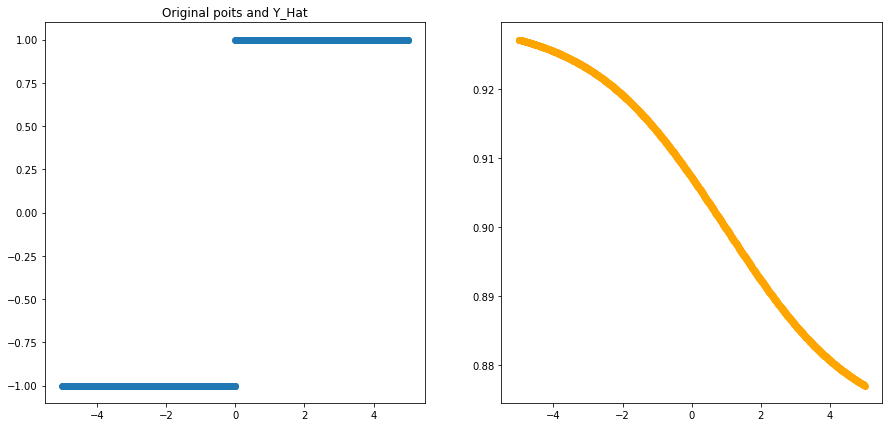

In [19]:
inputs,labels = toy()
y_hat = outputs = simple_network2(inputs)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.set_title('Original poits and labels')
ax1.scatter(inputs,labels);

ax1.set_title('Original poits and Y_Hat')
ax2.scatter(inputs,outputs,color='orange');

Note the huge difference in our y-axis! This is **without** and training so its bound to be bad! 

## Dealing with Biases

Another very common thing, as we saw in linear regression, was to add another dimension 

... to be continued ...

## Class-based Implementation

Michael Nielsen gives a simple class-based definition in his online textbook, which is very straight-forward to follow:

In [19]:
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

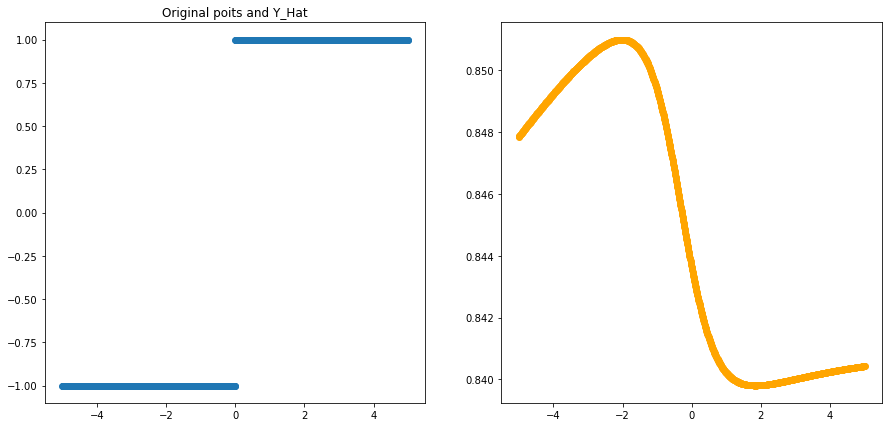

In [29]:
inputs,labels = toy()
network = Network([1,3,2,1])
outputs = network.feedforward(inputs.T).T

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.set_title('Original poits and labels')
ax1.scatter(inputs,labels);

ax1.set_title('Original poits and Y_Hat')
ax2.scatter(inputs,outputs,color='orange');

<div class="info">
    
**Pause-and-ponder**: This is a very common style of implementation - try to go back and understand it. Play with it, use it, try and break it! 
    
Do you understand why it works?
    
</div>

# Backprop

Alright! Now we're in a position to think about how to actually **use** this information to **improve** learning! 

In order to improve learning, we need to be able to explain how much **each parameter** is responsible for our overall error. So we somehow want to calculate and reason about:

$$
\frac{\partial C}{\partial w_1},\frac{\partial C}{\partial b_1},\frac{\partial C}{\partial w_2},\frac{\partial C}{\partial b_2},\frac{\partial C}{\partial w_3},\frac{\partial C}{\partial b_3}, \cdots
$$

Wow this got complicated really fast!

## Chain-rule

Before we continue, lets recall the chain rule from calculus:


Lets just focus on the last two layers: